In [1]:
from torchvision import datasets
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np
import torchvision.utils as vutils
import PIL.Image as Image
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
 
# DataLoader is used to load the dataset 
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)

In [3]:
# Model structure
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            nn.Linear(784, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
            nn.Tanh()
        )
    def forward(self, inputs):
        codes = self.encoder(inputs)
        return codes
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    def forward(self, inputs):
        outputs = self.decoder(inputs)
        return outputs

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = Encoder()
        # Decoder
        self.decoder = Decoder()    
    def forward(self, inputs): # 修改縮排20241226
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded

In [4]:
epochs = 30
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

cuda


In [5]:
model_ae = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=lr)
loss_function = torch.nn.MSELoss().to(device)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)

In [6]:
# Train
log_loss=[]
for epoch in range(epochs):
    total_loss = 0
    for data, _ in loader:
        inputs = data.view(-1, 784).to(device) 
        model_ae.zero_grad()
        # Forward
        codes, decoded = model_ae(inputs)
        loss = loss_function(decoded, inputs)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        log_loss.append(loss.data.cpu())
    total_loss /= len(loader.dataset)
    scheduler.step()
    
    if epoch % 5 ==0:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

[1/30] Loss: 0.0017610103823244572
[6/30] Loss: 0.0012058902066200972
[11/30] Loss: 0.0011270235991105437
[16/30] Loss: 0.0011027862783521414
[21/30] Loss: 0.0010880831396207213
[26/30] Loss: 0.0010787190403789282
[30/30] Loss: 0.001065590069629252


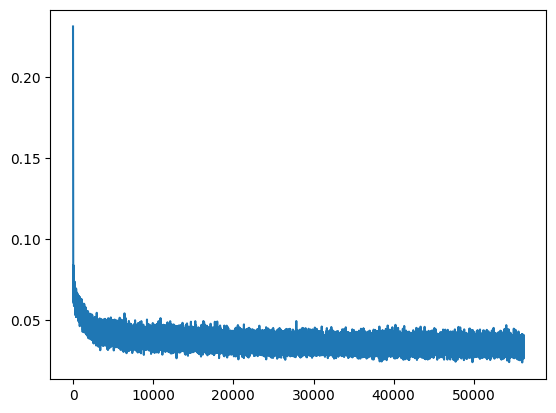

In [7]:
plt.plot(log_loss)

In [8]:
torch.save(model_ae, 'mode_AutoEncoder_MNIST.pth')

In [13]:
# Settings
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'# Show images
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')# Load model
model_ae = torch.load('mode_AutoEncoder_MNIST.pth')
model_ae.eval()# DataLoader
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, download=True, transform= transforms.ToTensor()),batch_size=20)# Test

Original Images


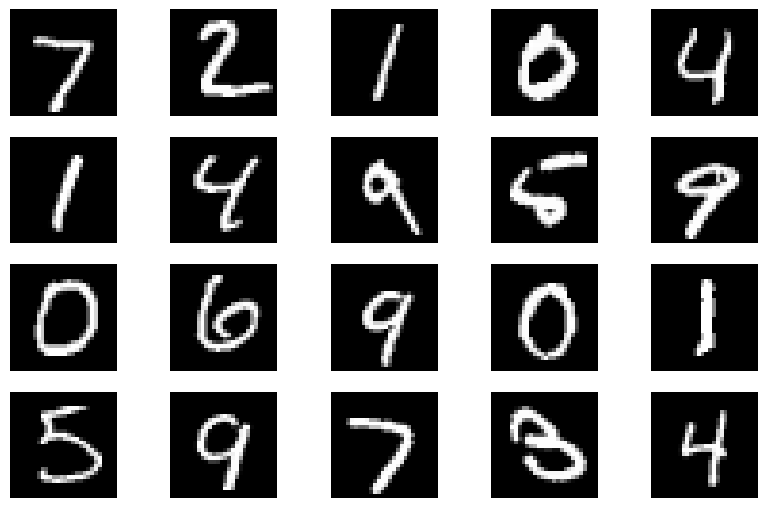

Restructured Image by AE


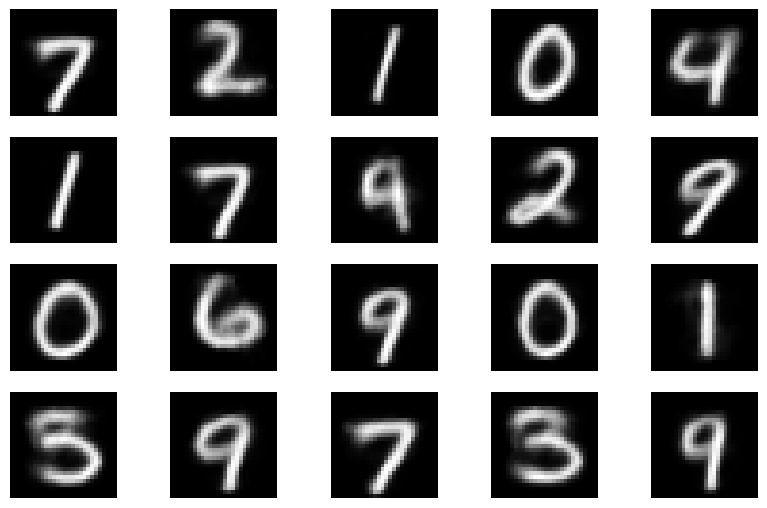

Original Images


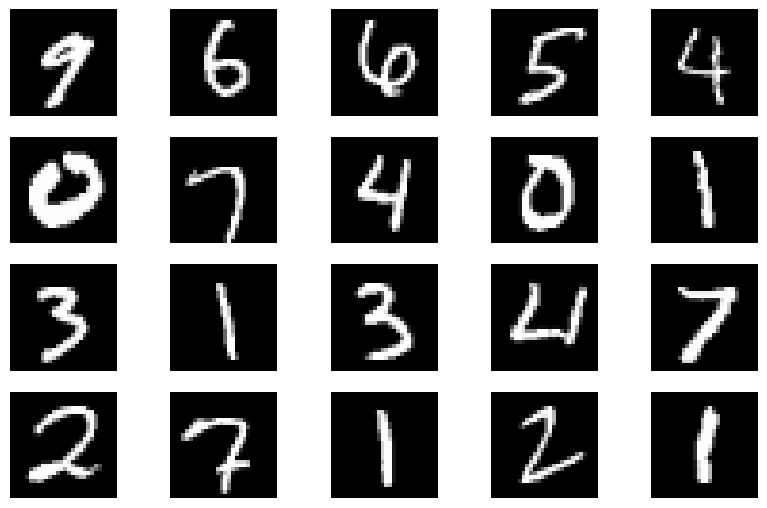

Restructured Image by AE


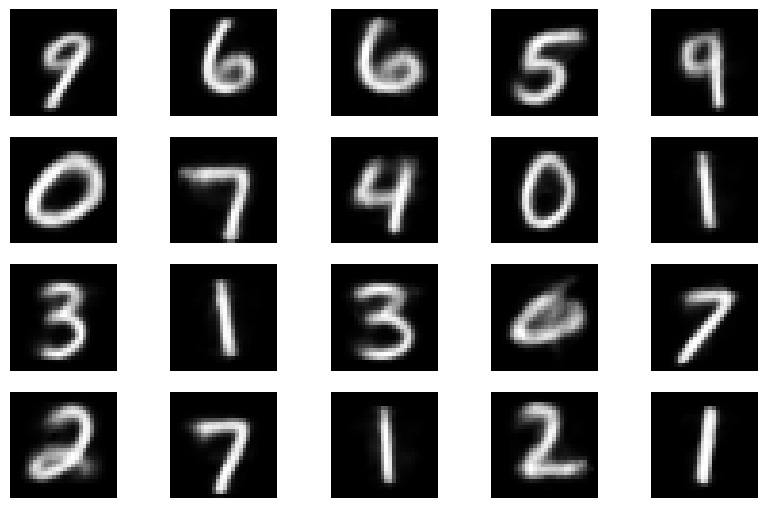

In [14]:
# Test
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        inputs = data.view(-1, 28*28)
        print('Original Images')
        show_images(inputs)
        plt.show()# Forward
        codes, outputs = model_ae(inputs.to(device))
        outputs = outputs.detach().cpu()
        print('Restructured Image by AE')
        show_images(outputs)
        plt.show()
        if i>0:
            break

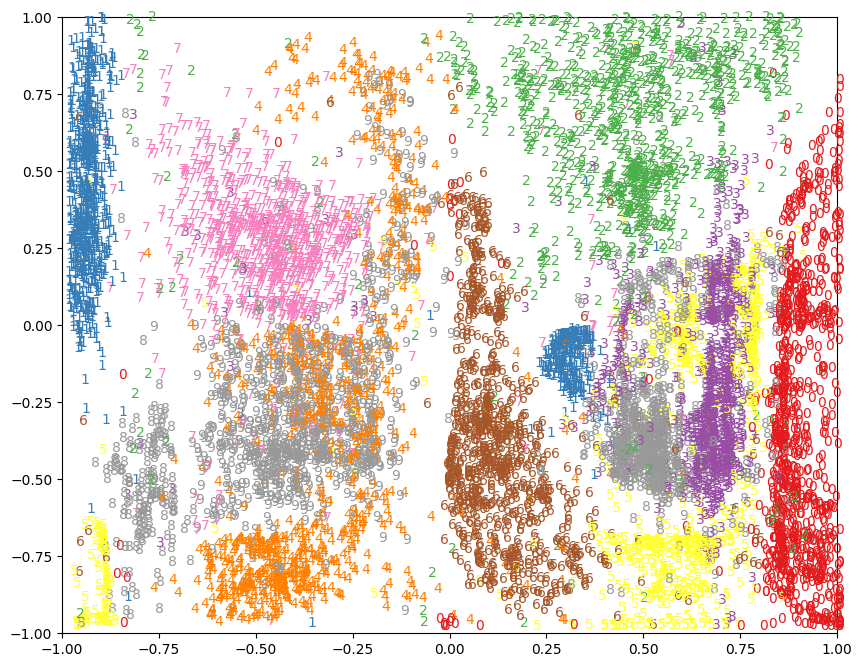

In [18]:
axis_x = []
axis_y = []
answers = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        inputs = data.view(-1, 28*28)
        answers += target.tolist()
        # Forward
        codes, outputs = model_ae(inputs.to(device))
        codes = codes.detach().cpu()
        axis_x += codes[:, 0].tolist()
        axis_y += codes[:, 1].tolist()
answers = np.array(answers)
axis_x = np.array(axis_x)
axis_y = np.array(axis_y)


fig, ax = plt.subplots()
for i in range(len(answers)):
    ax.text(axis_x[i], axis_y[i], str(answers[i]), color=plt.cm.Set1(answers[i]))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()